# InceptionTime for Binary Classification

Instead of classifying each behaviour, we just want to classify two distinct classes.

In [ ]:
import pandas as pd
from tsai.all import *
from sklearn.metrics import roc_auc_score, classification_report

## Loading and preparing the data

In [ ]:
df = pd.read_hdf("merged_20210405.h5")
print(f"Number of frames: {len(df)}")
df = df[(df['behavior'] != "not_defined")]
print(f"Number of frames after dropping non-labelled frames: {len(df)}")

background = ['standing', 'eating', 'walking', 'not_defined']

df.loc[~df['behavior'].isin(background), 'behavior'] = "anomaly"
#df.loc[df['behavior'].isin(background), 'behavior'] = "background"

Number of frames: 10424241
Number of frames after dropping non-labelled frames: 865548


<AxesSubplot:title={'center':'Training frames by behavior'}>

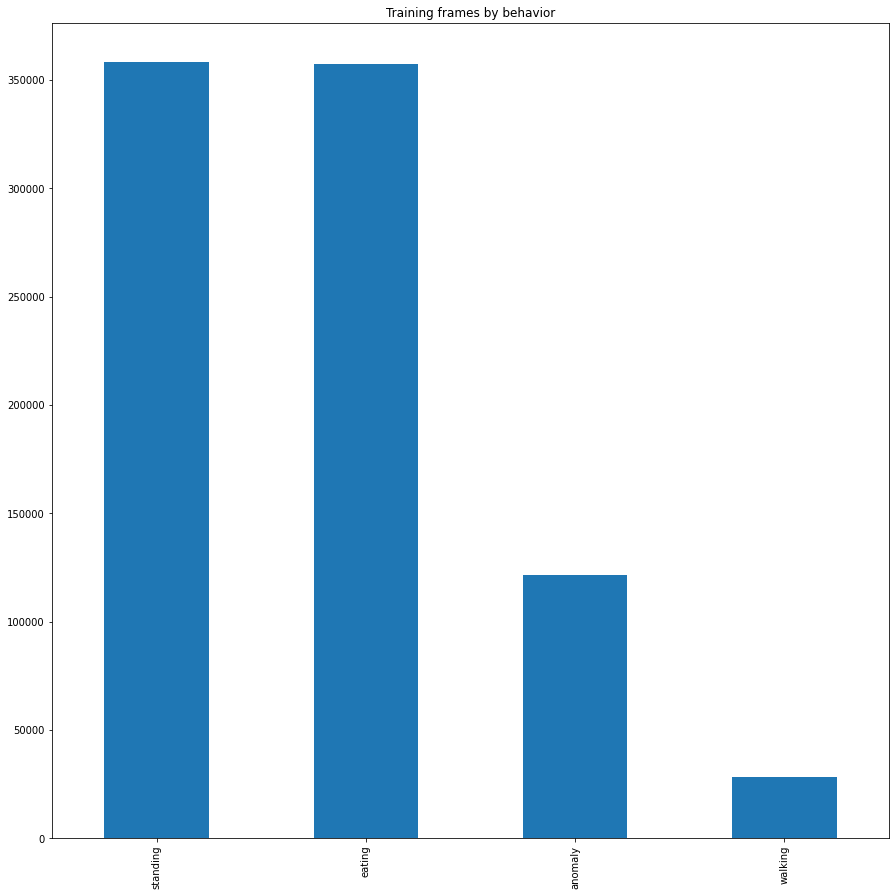

In [ ]:
df.behavior.value_counts().plot(kind='bar', figsize=(15,15), title='Training frames by behavior')

In [ ]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()

## 16 Frames

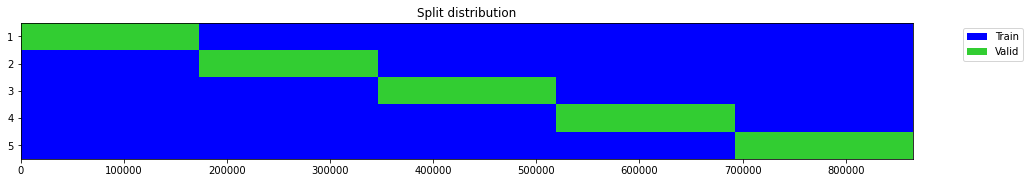

In [ ]:
x, y = SlidingWindow(16, get_x=features, get_y='behavior', y_func=y_func)(df)
splits = get_splits(y, n_splits=5, shuffle=False, stratify=True, check_splits=True)
tfms  = [None, [Categorize()]]

First some manual experiments to find some hyper parameters for the model. For this, we want to use the last split.

In [ ]:
bs = 1024

last_split = splits[-1]

tfms  = [None, [Categorize()]] 
dsets = TSDatasets(x, y, tfms=tfms, splits=last_split, inplace=True)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)



Minimum/10: 0.04365158379077912, steepest point: 0.007585775572806597


c:\users\kevin\.virtualenvs\winkie-dvdu7utg\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.233702,0.460341,0.875926,0.856722,00:05
1,0.189544,0.355751,0.898640,0.890161,00:05
2,0.163677,0.736874,0.740650,0.749313,00:05
3,0.151091,0.346637,0.907404,0.899130,00:05
4,0.132077,0.379553,0.903510,0.895569,00:05
5,0.122896,0.560747,0.849809,0.863526,00:05
6,0.113600,0.416366,0.901702,0.893220,00:05
7,0.102102,0.760088,0.793820,0.817141,00:05
8,0.096905,0.402944,0.908547,0.914045,00:05
9,0.089381,0.381985,0.908420,0.908870,00:05


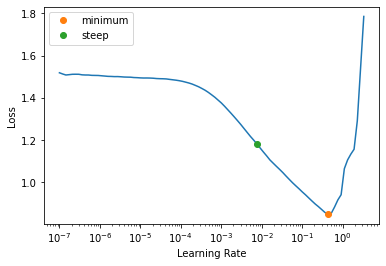

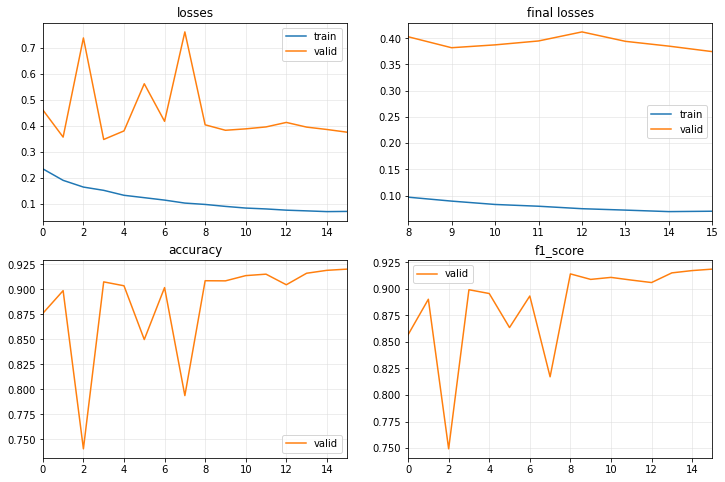

In [ ]:
model = InceptionTime(dls.vars, dls.c, depth=1, ks=20)
f1 = F1Score(average="weighted")
learn = Learner(dls, model, metrics=[accuracy, f1])
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min}, steepest point: {lr_steep}")

learn.fit_one_cycle(16, lr_max=lr_steep)
learn.recorder.plot_metrics()

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(10, 10), cmap='Blues')
# interp.plot_confusion_matrix(normalize=True, figsize=(10, 10), cmap='Blues')

In [ ]:
learn.save_all(path='inception_time_anomaly', dls_fname='dls', model_fname='model', learner_fname='learner')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


## Running on new video

### Predicting new video

In [ ]:
learn = load_learner_all(path='inception_time_anomaly', dls_fname='dls', model_fname='model', learner_fname='learner')

df_new = pd.read_hdf('233_boxhab_day1_labeled.h5')

background = ['standing', 'eating', 'walking', 'not_defined']

df_new.loc[~df_new['behavior'].isin(background), 'behavior'] = "anomaly"
#df_new.loc[df_new['behavior'].isin(background), 'behavior'] = "background"



In [ ]:
df_new['behavior'].value_counts()

standing    39102
eating      27704
walking      3878
anomaly      1241
Name: behavior, dtype: int64

In [ ]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]
def y_func(o): 
    return scipy.stats.mode(o, axis=1).mode.ravel()
x, y = SlidingWindow(16, get_x=features, get_y='behavior', y_func=y_func)(df_new)

In [ ]:
test_ds = learn.dls.dataset.add_test(x, y)
test_dl = learn.dls.valid.new(test_ds)

In [ ]:
probas, targets, preds = learn.get_preds(dl=test_dl, with_decoded=True,  act=None, save_preds=None, save_targs=None, reorder=False)

In [ ]:
probas

tensor([[2.2941e-03, 1.2894e-04, 9.9437e-01, 3.2084e-03],
        [2.3563e-03, 1.1572e-04, 9.9452e-01, 3.0059e-03],
        [2.7604e-03, 1.2106e-04, 9.9415e-01, 2.9669e-03],
        ...,
        [4.3394e-03, 1.0968e-03, 9.4095e-01, 5.3611e-02],
        [4.5621e-03, 1.1656e-03, 9.4253e-01, 5.1745e-02],
        [6.1891e-03, 1.1860e-03, 9.3102e-01, 6.1604e-02]])

In [ ]:
print(classification_report(targets, preds))

              precision    recall  f1-score   support

           0       0.19      0.52      0.28      1241
           1       0.95      0.94      0.94     27704
           2       0.91      0.88      0.90     39086
           3       0.48      0.43      0.45      3878

    accuracy                           0.87     71909
   macro avg       0.63      0.69      0.64     71909
weighted avg       0.89      0.87      0.88     71909



In [ ]:
new_preds = []
for i, x in enumerate(probas):
    argmax = np.argmax(x)
    ind = np.argpartition(x, -2)[-2:]
    
    anomaly_proba = x[0]
    background_proba = x[1]
    
    if (all(x in ind for x in [0, 1]) and anomaly_proba > 0.14):
        new_preds.append(0)
   # elif (all(x in ind for x in [3, 4]) and preening_proba > 0.1): 
        #new_preds.append(3)
    else:
        new_preds.append(argmax)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(new_preds, targets))

              precision    recall  f1-score   support

           0       0.52      0.19      0.28      3388
           1       0.94      0.95      0.94     27357
           2       0.88      0.91      0.90     37687
           3       0.43      0.48      0.45      3477

    accuracy                           0.87     71909
   macro avg       0.69      0.63      0.64     71909
weighted avg       0.86      0.87      0.86     71909



In [ ]:
import cv2
import numpy as np

np.set_printoptions(precision=2)

cap = cv2.VideoCapture('233_boxhab_gopro_cut_day1.MP4')
framerate = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('233_boxhab_gopro_cut_day1_pred_it.mp4', fourcc, framerate, (1280,  960))
frame_number = 0
while True:
    ret, frame = cap.read()
    if ret:

        b = str(preds[frame_number].item())
        proba = str(probas[frame_number])
        cv2.putText(frame, b, (70, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (130, 255, 130), 2, cv2.LINE_AA)
        cv2.putText(frame, proba, (70, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (130, 255, 130), 1, cv2.LINE_AA)
        
        
        for i, v in enumerate(probas[frame_number]):
#             label = clf.classes_[i]
            y_pos = 120 + 20 * i
            x_pos = 250
            
#             cv2.putText(frame, label, (70, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 1, (130, 255, 130), 1, cv2.LINE_AA)
            
            bar = (int(x_pos + 100 * probas[frame_number][i].item()), y_pos)
            cv2.line(frame, (x_pos, y_pos), bar, (0,0,255), 10)
        
        out.write(frame)

        frame_number = frame_number + 1
        if frame_number == 71908:
            break
    else:
        break

cap.release()
out.release()

In [ ]:
learn.save_all(path='inception_time', dls_fname='dls', model_fname='model', learner_fname='learner')